# Collaboration and Competition

---

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis_Linux/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

Episode 100	Average Score: 0.006 	Time/episode: 0.25
Episode 200	Average Score: 0.005 	Time/episode: 0.26
Episode 300	Average Score: 0.003 	Time/episode: 0.24
Episode 400	Average Score: 0.004 	Time/episode: 0.24
Episode 500	Average Score: 0.011 	Time/episode: 0.29
Episode 600	Average Score: 0.019 	Time/episode: 0.31
Episode 700	Average Score: 0.006 	Time/episode: 0.25
Episode 800	Average Score: 0.001 	Time/episode: 0.23
Episode 900	Average Score: 0.000 	Time/episode: 0.23
Episode 1000	Average Score: 0.002 	Time/episode: 0.24
Episode 1100	Average Score: 0.013 	Time/episode: 0.28
Episode 1200	Average Score: 0.009 	Time/episode: 0.27
Episode 1300	Average Score: 0.015 	Time/episode: 0.29
Episode 1400	Average Score: 0.010 	Time/episode: 0.28
Episode 1500	Average Score: 0.001 	Time/episode: 0.26
Episode 1600	Average Score: 0.004 	Time/episode: 0.25
Episode 1700	Average Score: 0.033 	Time/episode: 0.39
Episode 1800	Average Score: 0.045 	Time/episode: 0.44
Episode 1900	Average Score: 0.086 	Ti

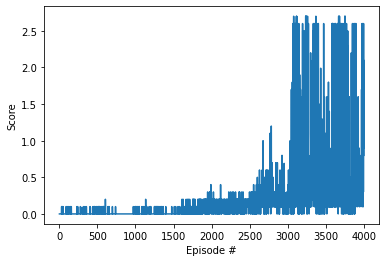

In [4]:
from maddpg import MADDPG
import torch
import numpy as np
import os
from utilities import *
import time
import matplotlib.pyplot as plt
%matplotlib inline

# amplitude of OU noise
# this slowly decreases to 0
noiseAmp = 2
noise_reduction = 0.9995
noise_lim = noiseAmp*0.05

maddpg = MADDPG()

load = False    # Load saved model
filename = "DDPG_Score_37.8.pth"

n_episodes = 4000
print_steps = 100
save_score = 0.5


# Load model
if load:
    agent.load_model(filename)
    
# get the current state (for each agent) so far only one agent is used
states = env_info.vector_observations
# initialize the score (for each agent)
scores = []
start = time.time()

for i_episode in range(1, n_episodes):                                      # play game for n episodes
    env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
    states = env_info.vector_observations                 # get the current state (for each agent)
    score = np.zeros(num_agents)                          # initialize the score (for each agent)

    while True:
        states_T = states_to_tensor(states)
        actions = maddpg.act(states_T, noise=noiseAmp)
        actions = action_to_environment(actions)
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = np.asarray(env_info.rewards, dtype=np.float32)   # get reward (for each agent)
        dones = np.asarray(env_info.local_done, dtype=np.float32)  # see if episode finished
        maddpg.step(states, actions, rewards, next_states, dones)
        score += env_info.rewards                          # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):
            break        

    # decrease noise level
    if noiseAmp > noise_lim:
        noiseAmp *= noise_reduction   

    scores.append(np.max(score))
    print('\rEpisode {}\tScore: {:.3f} \tNoise ampl.: {:.3f}'.format(i_episode, np.max(score), noiseAmp), end="")
           
    if i_episode % print_steps == 0:
        end = time.time()    
        mean_score = np.mean(scores[-print_steps:])
        print('\rEpisode {}\tAverage Score: {:.3f} \tTime/episode: {:.2f}'.format(i_episode, mean_score, (end-start)/print_steps,           end=""))
        start = end
        if mean_score >save_score:
            name = "MADDPG_V1_Score_{:.2f}".format(mean_score)
            maddpg.save_model(name, i_episode)
            save_score = mean_score      
            print('Agent saved! file="MADDPG_V1_Score_{:.2f}"'.format(mean_score))

    
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

# Test trained agent

In [1]:

!pip install imageio
# for saving gif
import imageio

load = True

maddpg = MADDPG()
load_filename = "./model_dir/MADDPG_V1_Score_1.13-episode-3700.pt"
if load:  # Run environment setup before loading agent
    maddpg.load_model(load_filename)

# save info or not
save_gif = True
frames = []
tmax = 0    

env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
n=0
while True:
    n+=1
    # select an action (for each agent)
    states_T = states_to_tensor(states)
    actions = maddpg.act(states_T)
    actions = action_to_environment(actions)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        print("time steps: ", n)
        break
    # save gif frame
    if save_gif:
        #frames.append(env.
        tmax+=1
print('Total score (averaged over agents) this episode: {:.2f}'.format(np.mean(scores)))

NameError: name 'MADDPG' is not defined